In [4]:
import numpy as np
import pandas as pd
import os
from pandas import read_csv
import tensorflow
from keras.models import Sequential
from keras.layers.core import Dropout
from keras.layers import  Dropout,ConvLSTM2D,Conv3DTranspose,Dense,ReLU
import imageio
from functools import reduce
import matplotlib.pyplot as plt
import cv2
import tqdm
import time
from datetime import datetime as dt
import tensorflow as tf
import scipy.stats
from scipy import stats


/usr/local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def unpivot(frame):
    N, K = frame.shape
    data = {
        "value": frame.to_numpy().ravel("F"),
        "lon": np.asarray(frame.columns).repeat(N),
        "lat": np.tile(np.asarray(frame.index), K),
    }
    return pd.DataFrame(data, columns=["lat", "lon", "value"])

## Pre-procesing

### Prepare SST

In [3]:
#conect to the bucket
bucket3 = 's3://acc-cmbc-vms/my-data/climate_scenarios/GFDL85/monthly_data' 
data_key3 = '_tos_gfdl_ssp585_1850_2014_monthly.csv' 
data_location3 = 's3://{}/{}'.format(bucket3,data_key3) 
sst0 = pd.read_csv(data_location3)
data_key4 = '_tos_gfdl_ssp585_2015_2100_monthly.csv' 
data_location4 = 's3://{}/{}'.format(bucket3,data_key4)
sst2 = pd.read_csv(data_location4)
sst = pd.concat([sst0, sst2], ignore_index = True, axis = 0)
sst = sst.set_index('date')
sst = sst.loc['2008-01-01':'2021-01-01']#extract only the data for the training
sst = sst.reset_index()
date = sst['date']
date_list1 = list(sst['date'])
tt = pd.DataFrame(date_list1)
date_list1 = tt[0].unique()
sst['date'] = pd.to_datetime(sst['date'])
sst = sst.set_index(['date'])
sst = sst.drop(columns=['esm','ssp'])
del sst0,sst2

In [4]:
def transo1(data,date_list):
    x1 = data.loc[date_list]
    x1 = x1.reset_index()
    op = data.columns
    table = pd.pivot_table(x1, values=op[0], index=['lat'],columns=['lon']).fillna(0)
    x2 = np.flipud(cv2.resize(np.array(table),[65,16]))
    dt = pd.DataFrame(x2, columns=col, index=ind)
    x = pd.DataFrame(unpivot(dt))
    fecha = np.repeat(date_list,len(x))
    x['date'] = fecha
    return x

In [5]:
def vectoriza(data,date_list):
    for i in tqdm.tqdm(range(0,len(date_list))):
        if i==0:
            x = transo1(data,date_list[i])
        else:
            x1 = transo1(data,date_list[i])
            x = pd.concat([x,x1], ignore_index = True, axis = 0)
    return x

In [6]:
table2 = pd.pivot_table(sst.loc['2008-01-01'], values='tos', index=['lat'],columns=['lon'])
col = np.array(table2.columns)
ind = np.array(table2.index)

In [7]:
sstv = vectoriza(sst,date_list1)

100%|██████████| 157/157 [00:01<00:00, 84.67it/s]


In [8]:
sstv.rename(columns = {'value':'tos'}, inplace = True)

### O2

In [9]:
data_key4 = '_o2_gfdl_ssp585_1850_2014_monthly.csv' #key or the name of the file
data_location4 = 's3://{}/{}'.format(bucket3,data_key4) #create the complete path in the format
O2_surf1 = pd.read_csv(data_location4)
data_key5 = '_o2_gfdl_ssp585_2015_2100_monthly.csv' #key or the name of the file
data_location4 = 's3://{}/{}'.format(bucket3,data_key5) #create the complete path in the format
O2_surf2 = pd.read_csv(data_location4)
O2 = pd.concat([O2_surf1, O2_surf2], ignore_index= True, axis=0)
O2 = O2.set_index('date')
O2 = O2.loc['2008-01-01':'2021-01-01']
O2 = O2.reset_index()
O2['date'] = pd.to_datetime(O2['date'])
O2 = O2.set_index(['date'])
O2 = O2.drop(columns=['esm','ssp'])
del O2_surf1, O2_surf2

In [10]:
o2v = vectoriza(O2,date_list1)


100%|██████████| 157/157 [00:01<00:00, 84.59it/s]


In [11]:
o2v.rename(columns = {'value':'o2'}, inplace = True)

### intpp

In [12]:
bucket4 = 's3://acc-cmbc-vms/my-data/climate_scenarios/GFDL85/monthly_data' #this is the paath to the data
data_key4 = '_intpp_gfdl_ssp585_1850_2014_monthly.csv' #key or the name of the file
data_location4 = 's3://{}/{}'.format(bucket3,data_key4) #create the complete path in the format
intpp1 = pd.read_csv(data_location4)
data_key5 = '_intpp_gfdl_ssp585_2015_2100_monthly.csv' #key or the name of the file
data_location4 = 's3://{}/{}'.format(bucket3,data_key5) #create the complete path in the format
intpp2 = pd.read_csv(data_location4)
intpp = pd.concat([intpp1, intpp2], ignore_index= True, axis=0)
intpp = intpp.set_index('date')
intpp = intpp.loc['2008-01-01':'2021-01-01']
intpp = intpp.reset_index()
intpp['date'] = pd.to_datetime(intpp['date'])
intpp = intpp.set_index(['date'])
intpp = intpp.drop(columns=['esm','ssp'])
del intpp1, intpp2

In [13]:
intppv  = vectoriza(intpp,date_list1)

100%|██████████| 157/157 [00:01<00:00, 85.16it/s]


In [14]:
intppv.rename(columns = {'value':'intpp'}, inplace = True)

###  pH

In [15]:
bucket4 = 's3://acc-cmbc-vms/my-data/climate_scenarios/GFDL85/monthly_data' #this is the paath to the data
data_key4 = '_ph_gfdl_ssp585_1850_2014_monthly.csv' #key or the name of the file
data_location4 = 's3://{}/{}'.format(bucket4,data_key4) #create the complete path in the format
pH1 = pd.read_csv(data_location4)
data_key5 = '_ph_gfdl_ssp585_2015_2100_monthly.csv' #key or the name of the file
data_location4 = 's3://{}/{}'.format(bucket4,data_key5) #create the complete path in the format
pH2 = pd.read_csv(data_location4)
pH = pd.concat([pH1, pH2], ignore_index= True, axis=0)
pH = pH.set_index('date')
pH = pH.loc['2008-01-01':'2021-01-01']
pH = pH.reset_index()
pH['date'] = pd.to_datetime(pH['date'])
pH = pH.set_index(['date'])
pH = pH.drop(columns=['esm','ssp'])
del pH1, pH2

In [16]:
pHv = vectoriza(pH,date_list1)

100%|██████████| 157/157 [00:01<00:00, 82.36it/s]


In [17]:
pHv.rename(columns = {'value':'pH'}, inplace = True)

### SO

In [18]:
bucket4 = 's3://acc-cmbc-vms/my-data/climate_scenarios/GFDL85/monthly_data' #this is the paath to the data
data_key4 = '_so_gfdl_ssp585_1850_2014_monthly.csv' #key or the name of the file
data_location4 = 's3://{}/{}'.format(bucket4,data_key4) #create the complete path in the format
so1 = pd.read_csv(data_location4)
data_key5 = '_so_gfdl_ssp585_2015_2100_monthly.csv' #key or the name of the file
data_location4 = 's3://{}/{}'.format(bucket4,data_key5) #create the complete path in the format
so2 = pd.read_csv(data_location4)
so = pd.concat([so1, so2], ignore_index= True, axis=0)
so = so.set_index('date')
so = so.loc['2008-01-01':'2021-01-01']
so = so.reset_index()
so['date'] = pd.to_datetime(so['date'])
so = so.set_index(['date'])
so = so.drop(columns=['esm','ssp'])
del so1, so2

In [19]:
sov  = vectoriza(so,date_list1)

100%|██████████| 157/157 [00:01<00:00, 82.20it/s]


In [20]:
sov.rename(columns = {'value':'so'}, inplace = True)

### Load VMS points

In [21]:
bucket = 's3://acc-cmbc-vms/my-data/datasets/fisheries_mtx' #this is the paath to the data
data_key = 'vms_data_point_one.csv' #key or the name of the file
data_location = 's3://{}/{}'.format(bucket,data_key) #create the complete path in the format
data = pd.read_csv(data_location)
data = data.drop(columns=['Unnamed: 0'])
data.rename(columns = {'latitude':'lat', 'longitude':'lon'}, inplace = True)
date_list = list(data['date'])
tt = pd.DataFrame(date_list)
date_list = tt[0].unique()
data = data.set_index(['date'])

#### Escalamiento de los datos de 0.1 a 0.5

In [22]:
def transo(data,date_list):
    x1 = data.loc[str(date_list)]
    x1 = x1.reset_index()
    table = pd.pivot_table(x1, values='yeld', index=['lat'],columns=['lon']).fillna(0)
    x2 = cv2.resize(np.array(table),[16,65])
    dt = pd.DataFrame(x2.transpose(), columns=col, index=ind)
    x = pd.DataFrame(unpivot(dt))
    fecha = np.repeat(date_list,len(x))
    x['date'] = fecha
    return x

In [23]:
for i in tqdm.tqdm(range(0,len(date_list))):
    if i==0:
        x = transo(data,date_list[i])
    else:
        x1 = transo(data,date_list[i])
        x = pd.concat([x,x1], ignore_index = True, axis = 0)

100%|██████████| 428/428 [00:09<00:00, 44.38it/s]


In [24]:
x.rename(columns = {'value':'yeld'}, inplace = True)

## Unión de tablas de input

In [25]:
datos = pd.DataFrame([sstv['date'],sstv['lat'],sstv['lon'],sstv['tos'],o2v['o2'],intppv['intpp'],pHv['pH'],sov['so']]).transpose()
datos['date'] = pd.to_datetime(datos['date'])
datos['date'] = datos['date'].dt.strftime('%Y-%m')

In [26]:
x['date'] = pd.to_datetime(x['date'])
x['date'] = x['date'].dt.strftime('%Y-%m')
DATA = x.merge(datos)
DATA.to_csv('DATA.csv')

### Datos para pronóstio

In [27]:
bucket3 = 's3://acc-cmbc-vms/my-data/climate_scenarios/GFDL85/monthly_data' 

data_key4 = '_tos_gfdl_ssp585_2015_2100_monthly.csv' 
data_location4 = 's3://{}/{}'.format(bucket3,data_key4)
ssti = pd.read_csv(data_location4)
ssti = ssti.set_index('date')
ssti = ssti.loc['2021-01-01':]
ssti = ssti.reset_index()
date_list2 = list(ssti['date'])
tt = pd.DataFrame(date_list2)
date_list2 = tt[0].unique()
ssti = ssti.set_index(['date'])
ssti = ssti.drop(columns=['esm','ssp'])
sstvi = vectoriza(ssti,date_list2)
sstvi.rename(columns = {'value':'tos'}, inplace = True)

data_key5 = '_o2_gfdl_ssp585_2015_2100_monthly.csv' #key or the name of the file
data_location4 = 's3://{}/{}'.format(bucket3,data_key5) #create the complete path in the format
O2i = pd.read_csv(data_location4)
O2i = O2i.set_index('date')
O2i = O2i.loc['2021-01-01':]
O2i = O2i.reset_index()
O2i['date'] = pd.to_datetime(O2i['date'])
O2i = O2i.set_index(['date'])
O2i = O2i.drop(columns=['esm','ssp'])
o2vi = vectoriza(O2i,date_list2)
o2vi.rename(columns = {'value':'o2'}, inplace = True)

data_key5 = '_intpp_gfdl_ssp585_2015_2100_monthly.csv' 
data_location4 = 's3://{}/{}'.format(bucket3,data_key5)
intppi = pd.read_csv(data_location4)
intppi = intppi.set_index('date')
intppi = intppi.loc['2021-01-01':]
intppi = intppi.reset_index()
intppi['date'] = pd.to_datetime(intppi['date'])
intppi = intppi.set_index(['date'])
intppi = intppi.drop(columns=['esm','ssp'])
intppvi  = vectoriza(intppi,date_list2)
intppvi.rename(columns = {'value':'intpp'}, inplace = True)

data_key5 = '_ph_gfdl_ssp585_2015_2100_monthly.csv' #key or the name of the file
data_location4 = 's3://{}/{}'.format(bucket3,data_key5) #create the complete path in the format
pHi = pd.read_csv(data_location4)
pHi = pHi.set_index('date')
pHi = pHi.loc['2021-01-01':]
pHi = pHi.reset_index()
pHi['date'] = pd.to_datetime(pHi['date'])
pHi = pHi.set_index(['date'])
pHi = pHi.drop(columns=['esm','ssp'])
pHvi = vectoriza(pHi,date_list2)
pHvi.rename(columns = {'value':'pH'}, inplace = True)

data_key5 = '_so_gfdl_ssp585_2015_2100_monthly.csv' #key or the name of the file
data_location4 = 's3://{}/{}'.format(bucket3,data_key5) #create the complete path in the format
soi = pd.read_csv(data_location4)
soi = soi.set_index('date')
soi = soi.loc['2021-01-01':]
soi = soi.reset_index()
soi['date'] = pd.to_datetime(soi['date'])
soi = soi.set_index(['date'])
soi= soi.drop(columns=['esm','ssp'])
sovi  = vectoriza(soi,date_list2)
sovi.rename(columns = {'value':'so'}, inplace = True)

datos2 = pd.DataFrame([sstvi['date'],sstvi['lat'],sstvi['lon'],sstvi['tos'],o2vi['o2'],intppvi['intpp'],pHvi['pH'],sovi['so']]).transpose()
datos2['date'] = pd.to_datetime(datos2['date'])
datos2['date'] = datos2['date'].dt.strftime('%Y-%m')
datos2.to_csv('input_fore.csv')

100%|██████████| 960/960 [00:19<00:00, 50.11it/s]


### Estandarización de los datos

In [28]:
def probabilidad(X):
    X=stats.zscore(X)
    P=scipy.stats.norm.sf(abs(X))
    return P

In [29]:
def mimax(X):
    Max = X.max()
    Min = X.min()
    Delta = Max - Min
    STD = (X-Min)/Delta 
    return STD,Max,Min

In [30]:
def demimax(X,Max,Min):
    DST = X*(Max-Min)+Min
    return DST

In [147]:
STD_yeld = probabilidad(DATA['yeld'])
STD_tos,Max_tos,Min_tos = mimax(DATA['tos'])
STD_o2,Max_o2,Min_o2 = mimax(DATA['o2'])
STD_intpp,Max_intpp,Min_intpp = mimax(DATA['intpp'])
STD_pH,Max_pH,Min_pH = mimax(DATA['pH'])
STD_so,Max_so,Min_so = mimax(DATA['so'])

In [148]:
STD_tos = np.expand_dims(STD_tos,axis=1)
STD_o2 = np.expand_dims(STD_o2, axis=1)
STD_intpp = np.expand_dims(STD_intpp, axis=1)
STD_pH = np.expand_dims(STD_pH, axis=1)
STD_so = np.expand_dims(STD_so, axis=1)

In [149]:
Input = np.append(STD_tos,STD_o2,axis=1) 
Input = np.append(Input,STD_intpp,axis=1)
Input = np.append(Input,STD_pH,axis=1)
Input = np.append(Input,STD_so,axis=1)

In [150]:
Target = np.expand_dims(STD_yeld, axis=1)

In [151]:
Input = np.asarray(Input).astype('float32')
Target = np.asarray(Target).astype('float32')

In [152]:
X_train, X_test= Input[0:346112,:] , Input[346112:,:]
Y_train, Y_test= Target[0:346112,:], Target[346112:,:]
X_train = X_train.reshape((X_train.shape[0], 1,X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [153]:
training_set_shape = X_train.shape
number_of_channels = 1
sample_shape = (training_set_shape[1], training_set_shape[2], number_of_channels)
print(f'Dataset shape: {training_set_shape}')
print(f'Sample shape: {sample_shape}')

Dataset shape: (346112, 1, 5)
Sample shape: (1, 5, 1)


## MODELO

In [154]:
import tensorflow
from keras.models import Sequential
from keras.layers.core import Dropout
from keras.layers import  Dropout,LSTM,Dense,ReLU,Conv1D
input_shape = (1,5,1)


In [155]:
model = Sequential()
model.add(Dense(10,activation='softmax'))
model.add(Dense(50,activation='linear'))
model.add(Dense(1,activation='linear')) #softmax
model.compile(loss='mse', optimizer='rmsprop' ,metrics=['poisson'])

In [156]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Vijilamos el proceso de entrenamiento para detenerlo cuando encuentre un óptimo.
callbacks = [EarlyStopping(monitor='val_loss', patience=25), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(X_train, Y_train, epochs=250, batch_size=1000,validation_data=(X_test, Y_test) ,verbose=1,shuffle=True, callbacks=callbacks)

Epoch 1/250
347/347 [==============================] - 2s 3ms/step - loss: 0.0053 - poisson: 0.8187 - val_loss: 0.0034 - val_poisson: 0.8155
Epoch 2/250
347/347 [==============================] - 1s 3ms/step - loss: 0.0037 - poisson: 0.8153 - val_loss: 0.0035 - val_poisson: 0.8156
Epoch 3/250
347/347 [==============================] - 1s 3ms/step - loss: 0.0037 - poisson: 0.8153 - val_loss: 0.0035 - val_poisson: 0.8156
Epoch 4/250
347/347 [==============================] - 1s 3ms/step - loss: 0.0037 - poisson: 0.8153 - val_loss: 0.0035 - val_poisson: 0.8156
Epoch 5/250
347/347 [==============================] - 1s 3ms/step - loss: 0.0036 - poisson: 0.8153 - val_loss: 0.0036 - val_poisson: 0.8157
Epoch 6/250
347/347 [==============================] - 1s 3ms/step - loss: 0.0036 - poisson: 0.8153 - val_loss: 0.0035 - val_poisson: 0.8157
Epoch 7/250
347/347 [==============================] - 1s 3ms/step - loss: 0.0036 - poisson: 0.8153 - val_loss: 0.0034 - val_poisson: 0.8155
Epoch 8/250
3

2704/2704 [==============================] - 2s 846us/step - loss: 0.0035 - poisson: 0.8157
Test loss: 0.003539998084306717
Test accuracy: 0.8156507015228271


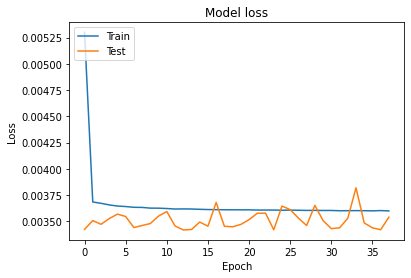

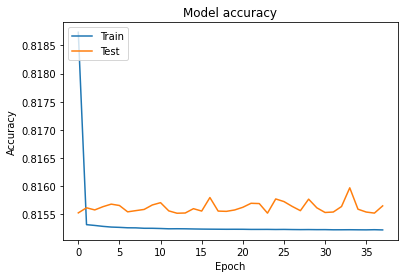

In [157]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history.history['poisson'])
plt.plot(history.history['val_poisson'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [158]:
te = model(X_test)
#te = demimax(np.array(te[:,0,0]),Max_yeld,Min_yeld)
model.save('Best1_model.h5')

In [159]:
New_data = DATA.loc[346112:]
New_data = New_data.reset_index()

In [160]:
A = pd.DataFrame(np.reshape(te,(86528,)))

In [161]:
A.rename(columns = {0:'Forecas_yeld'}, inplace = True)

In [162]:
New_data.insert(0,'Forecast_yeld',A)

In [163]:
New_data=New_data.set_index(['date','lat','lon'])

In [164]:
Dt=New_data.loc['2021-01']
Dt = Dt.reset_index()

In [165]:
Dt.to_csv('test_own_model.csv')

## Forecast 2021:2100

#### pre procesing the input

In [166]:
STD_tos = datos2['tos']
STD_o2 = datos2['o2']
STD_intpp = datos2['intpp']
STD_pH = datos2['pH']
STD_so = datos2['so']

STD_tos = np.expand_dims(STD_tos,axis=1)
STD_o2 = np.expand_dims(STD_o2, axis=1)
STD_intpp = np.expand_dims(STD_intpp, axis=1)
STD_pH = np.expand_dims(STD_pH, axis=1)
STD_so = np.expand_dims(STD_so, axis=1)

Input = np.append(STD_tos,STD_o2,axis=1) 
Input = np.append(Input,STD_intpp,axis=1)
Input = np.append(Input,STD_pH,axis=1)
Input = np.append(Input,STD_so,axis=1)
Input = np.asarray(Input).astype('float32')

X_test= Input[:,:]
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Pb = model.predict(X_test)
Pb =  pd.DataFrame(np.reshape(Pb,(998400,)))
Pb.rename(columns = {0:'Forecas_yeld_P'}, inplace = True)


In [167]:
New_data = datos2
New_data = New_data.reset_index()
New_data.insert(0,'Forecast_yeld_P',Pb)
New_data=New_data.set_index(['date','lat','lon'])


In [168]:
Dt=New_data.loc['2021-01':'2030-01']
#Dt=New_data.loc['2021-01':]
Dt = Dt.reset_index()
Dt.to_csv('Forecast2_own_model.csv')

In [7]:
Dt=read_csv('Forecast2_own_model.csv')

In [59]:
Fechas=list(Dt['date'].unique())
area=[]
for i in Fechas:
    A=Dt[Dt['date']== i]
    table = pd.pivot_table(A, values='Forecast_yeld_P', index=['lat'],columns=['lon']).fillna(0)
    area.append(table[table > 0.44].count().sum())


In [58]:
area

[]

In [62]:
Fechas=list(Dt['date'].unique())
P_mean=[]
P_std=[]
P_min=[]
P_max=[]
for i in Fechas:
    A=Dt[Dt['date']== i]
    P_mean.append(A['Forecast_yeld_P'].mean())
    P_std.append(A['Forecast_yeld_P'].std())
    P_min.append(A['Forecast_yeld_P'].min())
    P_max.append(A['Forecast_yeld_P'].max())
    
import imageio
a=0
filenames = []
li_max = Dt['Forecast_yeld_P'].max()+(Dt['Forecast_yeld_P'].max()*0.01)
li_min = Dt['Forecast_yeld_P'].min()-(Dt['Forecast_yeld_P'].min()*0.01)

for i in Fechas:
    A=Dt[Dt['date']== i]
    table = pd.pivot_table(A, values='Forecast_yeld_P', index=['lat'],columns=['lon']).fillna(0)
    fig = plt.subplots()


    plt.subplot(3, 1, 1)
    im = plt.imshow(table, vmin=0.410,vmax=0.485)
    plt.colorbar(im, pad=0.01)
    plt.suptitle(f'probabilidad de pesca por cuadrante, fecha: {i}')
    plt.subplot(3 ,1, 2)
    plt.plot(P_mean)
    plt.plot(a,P_mean[a],'ro')
    
    plt.subplot(3 ,1, 3)
    plt.plot(area)
    plt.plot(a,area[a],'bo')
    
    a = a+1
    
    filename = f'A{i}.png'
    filenames.append(filename)
    plt.savefig(filename)
    plt.close()

with imageio.get_writer('mygif01.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        for i in range(5):
            writer.append_data(image)

for filename in set(filenames):
    os.remove(filename)

In [ ]:
print(Max_tos,Min_tos)
print(Max_o2,Min_o2)
print(Max_intpp,Min_intpp)
print(Max_pH,Min_pH)
print(Max_so,Min_so)